
# Methodology:

Here we use different methodologies to find the best model to determine the correlation between 'SeriousDlqin2yrs' and other credit parameters of a customer.

First we load the cleaned and analysed csv file as obtained from Credit Guard_EDA notebook. Then we deploy different models to fit the data like : linear regression, logistic regression, random forest and XGboost.

We find in the end that XGBoost model gives the best performance w.r.t the AUC metric.

We also create a method of predicting what 3 credit parameters can be improved for a customer to not meet with serious delinquencies. We also try it for different models.

## 1. Python packages and libraries


In [ ]:
import torch, pandas as pd, numpy as np, seaborn as sns, itertools
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score, RocCurveDisplay, make_scorer
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, RandomizedSearchCV
from itertools import combinations, chain
from xgboost import XGBClassifier

## 2. Dataset importing (Cleaned Dataframe after EDA)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/tanujmath/CreditGuard/main/data/cs-training-new.csv')
df.head()

,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,NumberOfTimeLate
0,1,1,0.766127,45,0.802982,9120.0,13,6,2.0,0.333333
1,2,0,0.957151,40,0.121876,2600.0,4,0,1.0,0.000000
2,3,0,0.658180,38,0.085113,3042.0,2,0,0.0,0.666667
3,4,0,0.233810,30,0.036050,3300.0,5,0,0.0,0.000000
4,5,0,0.907239,49,0.024926,63588.0,7,1,0.0,0.166667


# 3. Data Scaling

Ofcourse we do not need all the columns scaled. We only used scaled version of the columns that are used in the regression. Also, it is not sensible to scale the column about Serious Delinquincies.  

We ran our models for both scaled and non-scaled data. We found that except for linear regression, the other models give more or less the same AUC score for scaled-nonscaled data. The linear regression model performs better for scaled data. Hence we do a global scaling for all the methods here.

In [ ]:
# first we make a deep copy of the engineered data

# first make a deep copy of the data
df2=df.copy(deep=True)
# standardization of columns (subtract mean and divide by variance)

## Make a scaler object : i.e. the StandardScaler object below which will know what to do make the standardization in the way we want
scaler=StandardScaler()

## fit the scaler : calling 'fit' means, the case of standardizing here, knowing the columns and the mean, standard deviation of the each of the columns
scaler.fit(df2)

#let us see the new dataset
df2.head()

# scaling the data
df_scale =scaler.transform(df2)

# creating an array with the scaled regression quantities we care about:

X=df_scale[:,[2,4,5,6,7,8,9]]

y=df2['SeriousDlqin2yrs']

X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                   random_state=14,
                                   test_size=0.2,
                                   shuffle=True)

# 4. Linear Regression Model

### 4a. Regression without Regularization

In [ ]:
# Linear Regression with standardized data
# we fit  the column of 'Serious Delinquencies in 2 years' of df2 with all the standardized columns starting from age in df_scale. We do train_test split and then calculate the MSE

reg = LinearRegression(copy_X=True, fit_intercept=True)


reg.fit(X_train,y_train)

#print(reg.coef_) # printing the regularization coeffs


# bringing the predicted score between 0 and 1
y_pred= reg.predict(X_test)
y_pred=(y_pred-min(y_pred))/(max(y_pred)-min(y_pred))


# Calculate the AUC
auc = roc_auc_score(y_test, y_pred)
print(f"AUC for linear regression without regularization is {auc}")

# MSE calculation for test set
MSE = mean_squared_error(y_test, np.around(y_pred), squared=False)  # squarred false means it will do a squareroot of MSE in the end
print(f"MSE for linear regression without regularization is {MSE}")


AUC for linear regression without regularization is 0.660196545736871
MSE for linear regression without regularization is 0.2603696999182155


### 4b. Linear Regression with Ridge Regularization

In [ ]:
alpha_Hyperparams = (0.001, 0.01, 0.1, 0.5, 0.75, 1.0, 10.0)
MSE_best = 1000
alpha_best = 0

for i in alpha_Hyperparams:
  reg_ridge = Ridge(alpha=i, fit_intercept=True, copy_X=True) # we take the regression hyperparam to be 0.5 for now, but its an hyperparameter and we should experiment with it
  reg_ridge.fit(X_train, y_train)
  MSE = mean_squared_error(y_test, np.around(reg_ridge.predict(X_test)), squared=False)
  auc = roc_auc_score(y_test, reg_ridge.predict(X_test))
  if MSE < MSE_best:
    MSE_best = MSE
    alpha_best = i
    auc_best = auc

print(f"The best MSE for linear regression with ridge regularization is {MSE_best} for alpha = {alpha_best}.")
print(f"The AUC here is {auc_best}")

The best MSE for linear regression with ridge regularization is 0.2603696999182155 for alpha = 0.001.
The AUC here is 0.660196545736871


### 4c. Linear Regression with Lasso Regularization

In [ ]:
alpha_Hyperparams = (0.001, 0.01, 0.1, 0.5, 0.75, 1.0, 10.0)
MSE_best = 1000
alpha_best = 0

for i in alpha_Hyperparams:
  reg_lasso = Lasso(alpha=i, fit_intercept=True, copy_X=True) # we take the regression hyperparam to be 0.5 for now, but its an hyperparameter and we should experiment with it
  reg_lasso.fit(X_train, y_train)
  MSE = mean_squared_error(y_test, np.around(reg_lasso.predict(X_test)), squared=False)
  auc = roc_auc_score(y_test, reg_lasso.predict(X_test))
  if MSE < MSE_best:
    MSE_best = MSE
    alpha_best = i
    auc_best = auc

print(f"The best MSE for linear regression with lasso regularization is {MSE_best} for alpha = {alpha_best}.")
print(f"The AUC here is {auc_best}")

The best MSE for linear regression with lasso regularization is 0.2603696999182155 for alpha = 0.001.
The AUC here is 0.6651118413542652


## 5. Logistic Regression model


First, we apply a logistic regression model on the training data using random hyperparameters and check the AUC score. Then, we see use two hyperparameter tuning methods to improve the AUC score.

In [ ]:
##Define the feature space and the target space

#Define the model with random hyperparameters
logit = LogisticRegression(random_state=123, solver='saga',
                           penalty='l1', class_weight='balanced',
                           C=1.0, max_iter=1000)

#Fit data into the model
logit.fit(X_train, y_train)

#Predict probabilities
logit_scores_proba = logit.predict_proba(X_test)
preds = logit_scores_proba[:,1]  # predictions

#Printing area under curve
print('AUC Score : ', round(roc_auc_score(y_test,preds),5) )

AUC Score :  0.78308


### 5a. Hyperparameter tuning

In [ ]:
# Initialize logistic regression model
model = LogisticRegression(solver='liblinear')

# Define hyperparameters to tune
hyperparameters = {'C': np.logspace(-2, 2, 10), 'penalty': ['l1', 'l2'],
                   'max_iter': list(range(200,1200,100))}

# Define scorer based on AUC
scorer = make_scorer(roc_auc_score, needs_proba=True)

## GRIDSEARCH

# Initialize GridSearchCV
gridsearch = GridSearchCV(model, hyperparameters, scoring=scorer, cv=5)

# Fit GridSearchCV on training data
gridsearch.fit(X_train, y_train)

# Get the best model
best_model = gridsearch.best_estimator_


# Predict probabilities on test data using the best model
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc = round(roc_auc_score(y_test, y_pred_proba),5)

print(f'The AUC of the test set through gridsearch tuning is {auc}')

## RANDOMSEARCH

# Initialize RandomizedSearchCV
randomsearch = RandomizedSearchCV(model, hyperparameters, scoring=scorer, cv=5)

# Fit RandomizedSearchCV on training data
randomsearch.fit(X_train, y_train)

# Get the best model
best_model = randomsearch.best_estimator_

print(randomsearch.best_params_)

# Predict probabilities on test data using the best model
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc = round(roc_auc_score(y_test, y_pred_proba),5)

print(f'The AUC of the test set through randomsearch tuning is {auc}')


The AUC of the test set through gridsearch tuning is 0.76822
{'penalty': 'l2', 'max_iter': 1000, 'C': 0.0001}
The AUC of the test set through randomsearch tuning is 0.65298


## 6. Random Forests

In [ ]:
# Define the model
rf = RandomForestClassifier()

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'n_jobs': [-1]
}

# Define scorer based on AUC
scorer = make_scorer(roc_auc_score, needs_proba=True)

# Initialize RandomizedSearchCV
randomsearch = RandomizedSearchCV(rf, param_grid, scoring=scorer, cv=5, verbose = 1)

# Fit RandomizedSearchCV on training data
randomsearch.fit(X_train, y_train)

# Get the best model
best_model = randomsearch.best_estimator_

# Get the best parameters
best_params = randomsearch.best_params_
print(f"Best parameters: {best_params}")

# Fit the model with the best parameters
rf_best = RandomForestClassifier(**best_params)
rf_best.fit(X_train, y_train)

# Make predictions
y_pred = rf_best.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model
auc = round(roc_auc_score(y_test, y_pred_proba),5)

print(f"AUC: {auc}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


## 7. XGBoost

In [ ]:
# Define the model. If GPU is present, use GPU.
model = XGBClassifier(tree_method='hist', device = 'cuda')

# Define the parameters for the RandomizedSearch
params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}

#Initialize randomized search
random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=5,
                                   scoring='roc_auc', n_jobs=-1, cv=5, verbose=1)

# Fit the model to the training data
random_search.fit(X_train, y_train)

# Make predictions
y_pred = random_search.predict(X_test)
y_pred_proba = random_search.predict_proba(X_test)[:, 1]

# Evaluate the model
auc = roc_auc_score(y_test, y_pred_proba)

print(f"AUC: {auc}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:18:16] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


AUC: 0.842162298042981


#Conclusion

We see that among all the different models that were applied to the dataset, XGBoost performs the best. To see this we use AUC metric. The AUC scores look like -




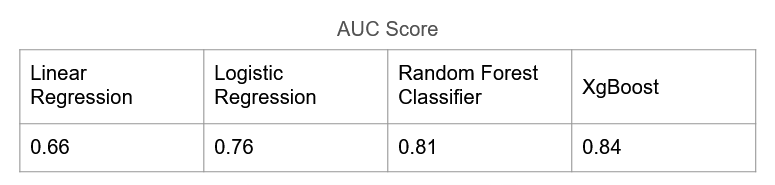